In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [3]:
n_epochs = 30  # number of optimization epochs being used
n_layers = 1    # number of random layers
n_train = 50    # size of the train dataset
n_test = 30    # size of the test dataset

SAVE_PATH = "/Users/priyaltaneja/Desktop/QNN/" # folder to save data
PREPROCESS = True           # if False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # seed for numpy random number generator
tf.random.set_seed(0)       # seed for tensorflow random number generator

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

train_images = "/Users/priyaltaneja/Downloads/chest_xray/train/"

train_generator = train_datagen.flow_from_directory(train_images,
    target_size = (300,300),
    batch_size = n_train,
    class_mode = 'binary',
    color_mode='grayscale')

train_labels = train_generator.classes[:n_train]

Found 5216 images belonging to 2 classes.


In [5]:
# get a batch of data
x_batch, y_batch = next(train_generator)

# check the shape of the batch
print(x_batch.shape) 

(50, 300, 300, 1)


In [6]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
test_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_images = "/Users/priyaltaneja/Downloads/chest_xray/test/"

test_generator = test_datagen.flow_from_directory(test_images,
    target_size= (300,300),
    batch_size = n_test,
    class_mode = 'binary',
    color_mode='grayscale')

test_labels = test_generator.classes [:n_test]

Found 624 images belonging to 2 classes.


In [8]:
# get a batch of data
x_batch, y_batch = next(test_generator)

# check the shape of the batch
print(x_batch.shape)

(30, 300, 300, 1)


In [9]:
dev = qml.device("default.qubit", wires=4)
# random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [10]:
def quanv(images):
    """Convolves the input images with many applications of the same quantum circuit."""
    out = np.zeros((images.shape[0], 14, 14, 4))

    # loop over the batch of images
    for i in range(images.shape[0]):
        # loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, 28, 2):
            for k in range(0, 28, 2):
                # process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        images[i, j, k, 0],
                        images[i, j, k + 1, 0],
                        images[i, j + 1, k, 0],
                        images[i, j + 1, k + 1, 0]
                    ]
                )
                # assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                    out[i, j // 2, k // 2, c] = q_results[c]
    return out

In [11]:
# QUANTUM PRE-PROCESSING OF THE DATASET 

if PREPROCESS == True:
    q_train_generator = quanv(train_generator.next()[0])
    for idx in range(1, n_train//train_generator.batch_size):
        q_train_generator = np.vstack((q_train_generator, quanv(train_generator.next()[0])))
    print("Quantum pre-processing of train images complete.")

    q_test_generator = quanv(test_generator.next()[0])
    for idx in range(1, n_test//test_generator.batch_size):
        q_test_generator = np.vstack((q_test_generator, quanv(test_generator.next()[0])))
    print("Quantum pre-processing of test images complete.")

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_generator.npy", q_train_generator)
    np.save(SAVE_PATH + "q_test_generator.npy", q_test_generator)

Quantum pre-processing of train images complete.
Quantum pre-processing of test images complete.


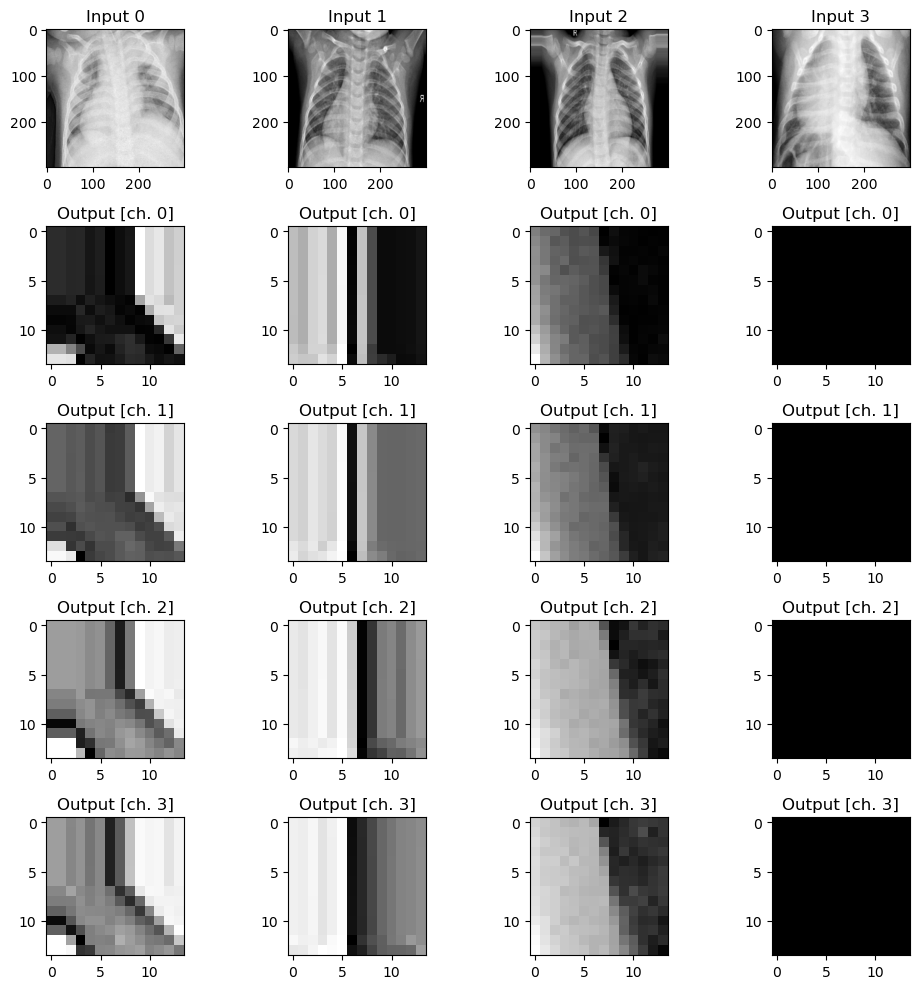

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, k].set_title("Input {}".format(k))
    axes[0, k].imshow(train_generator[k][0][0], cmap="gray")
    for c in range(n_channels):
        axes[c+1, k].set_title("Output [ch. {}]".format(c))
        axes[c+1, k].imshow(q_train_generator[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [14]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [16]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_generator,
    train_labels,
    validation_data=(q_test_generator, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 0.1264 - accuracy: 0.9800 - val_loss: 0.0419 - val_accuracy: 1.0000 - 696ms/epoch - 54ms/step
Epoch 2/30
13/13 - 0s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000 - 61ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000 - 102ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000 - 93ms/epoch - 7ms/step
Epoch 5/30
13/13 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000 - 68ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 - 69ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000 - 75ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000 - 83ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s

In [20]:
c_model = MyModel()

c_history = c_model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=test_generator,
    batch_size=4,
    verbose=2,
)

Epoch 1/30
105/105 - 121s - loss: 1.3897 - accuracy: 0.7975 - val_loss: 1.0770 - val_accuracy: 0.7580 - 121s/epoch - 1s/step
Epoch 2/30
105/105 - 126s - loss: 1.1406 - accuracy: 0.8167 - val_loss: 1.3053 - val_accuracy: 0.7885 - 126s/epoch - 1s/step
Epoch 3/30
105/105 - 117s - loss: 1.4127 - accuracy: 0.8204 - val_loss: 1.1760 - val_accuracy: 0.8077 - 117s/epoch - 1s/step
Epoch 4/30
105/105 - 108s - loss: 0.9175 - accuracy: 0.8666 - val_loss: 0.8831 - val_accuracy: 0.8237 - 108s/epoch - 1s/step
Epoch 5/30
105/105 - 104s - loss: 0.9425 - accuracy: 0.8604 - val_loss: 0.7825 - val_accuracy: 0.8317 - 104s/epoch - 989ms/step
Epoch 6/30
105/105 - 107s - loss: 0.7225 - accuracy: 0.8646 - val_loss: 0.9320 - val_accuracy: 0.8269 - 107s/epoch - 1s/step
Epoch 7/30
105/105 - 124s - loss: 0.8406 - accuracy: 0.8581 - val_loss: 0.7094 - val_accuracy: 0.8381 - 124s/epoch - 1s/step
Epoch 8/30
105/105 - 101s - loss: 1.2285 - accuracy: 0.8420 - val_loss: 3.2952 - val_accuracy: 0.7308 - 101s/epoch - 959ms

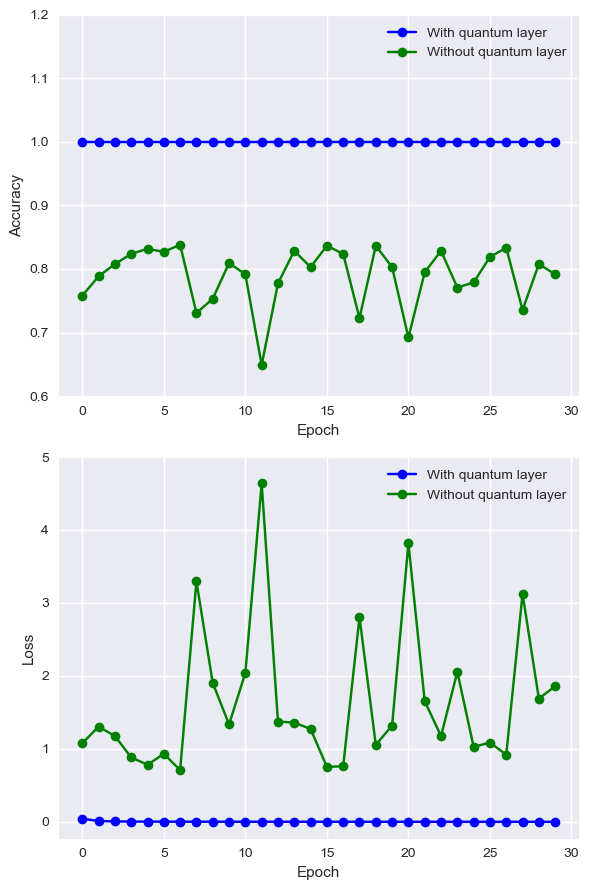

In [36]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0.6, 1.2])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()